<a href="https://www.kaggle.com/code/krishnadeshpande2907/emotional-analysis-of-audio-lstm?scriptVersionId=206170799" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Modules

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import random
import torch
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

2024-11-07 05:36:27.599831: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 05:36:27.599949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 05:36:27.729887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [5]:
torch.cuda.device_count()

1

In [6]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
import torch
print(torch.cuda.is_available())

True


# Loading the Dataset

In [8]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
# IEMOCAP = ""

## TESS

In [9]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])


In [10]:
# Joining them both
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0     fear  /kaggle/input/toronto-emotional-speech-set-tes...
1     fear  /kaggle/input/toronto-emotional-speech-set-tes...
2     fear  /kaggle/input/toronto-emotional-speech-set-tes...
3     fear  /kaggle/input/toronto-emotional-speech-set-tes...
4     fear  /kaggle/input/toronto-emotional-speech-set-tes...

<Axes: xlabel='Emotions', ylabel='count'>

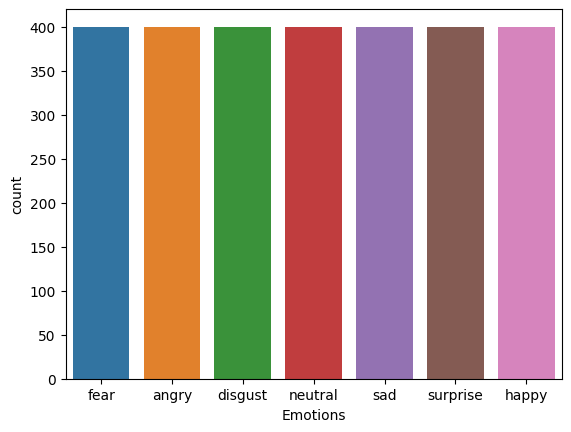

In [11]:
sns.countplot(data=Tess_df, x='Emotions')

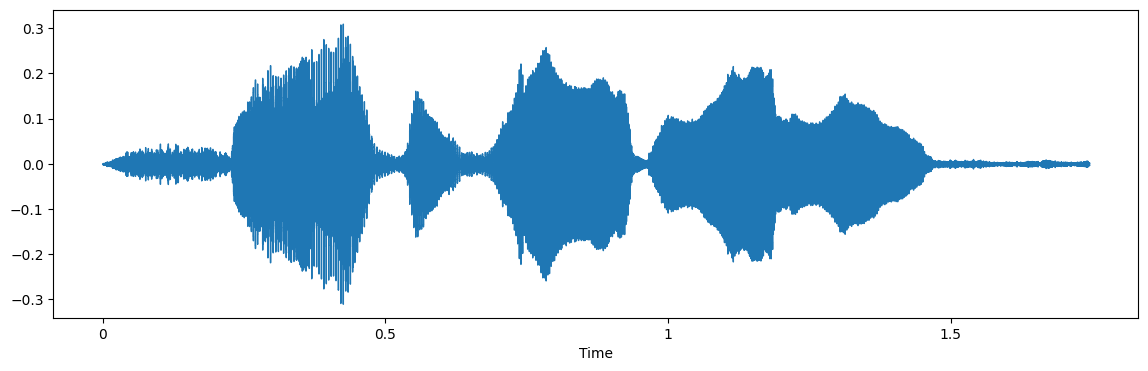

In [12]:
# Sample Audio
path = np.array(Tess_df.Path)[1]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

## Ravdess

In [13]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

In [14]:
# Joining them both
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

<Axes: xlabel='Emotions', ylabel='count'>

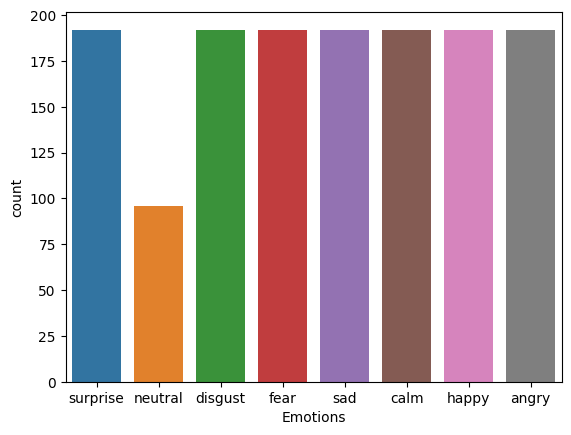

In [15]:
sns.countplot(data=Ravdess_df, x='Emotions')

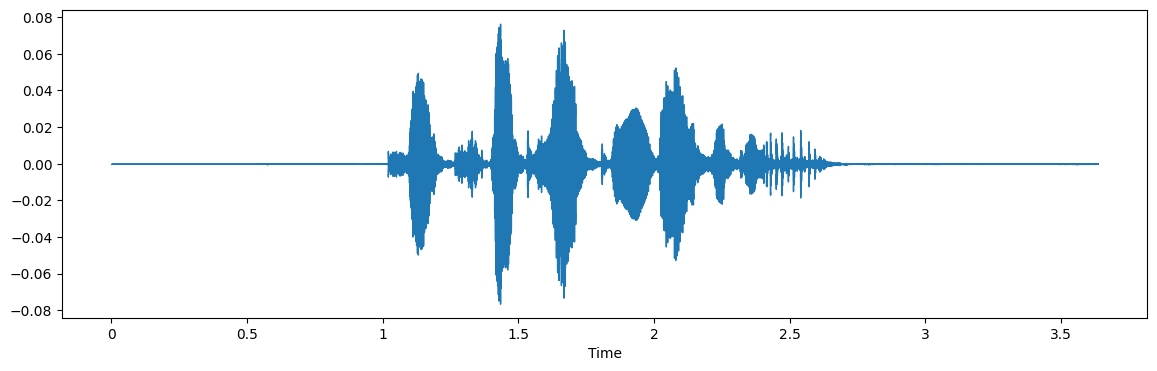

In [16]:
# Sample Audio
path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

## Crema-D

In [17]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

In [18]:
# Joining them both
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0  disgust  /kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1    happy  /kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2    happy  /kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3  disgust  /kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4  disgust  /kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav

<Axes: xlabel='Emotions', ylabel='count'>

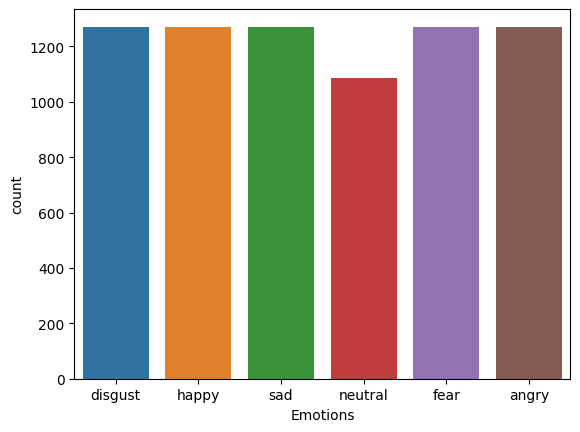

In [19]:
sns.countplot(data=Crema_df, x='Emotions')

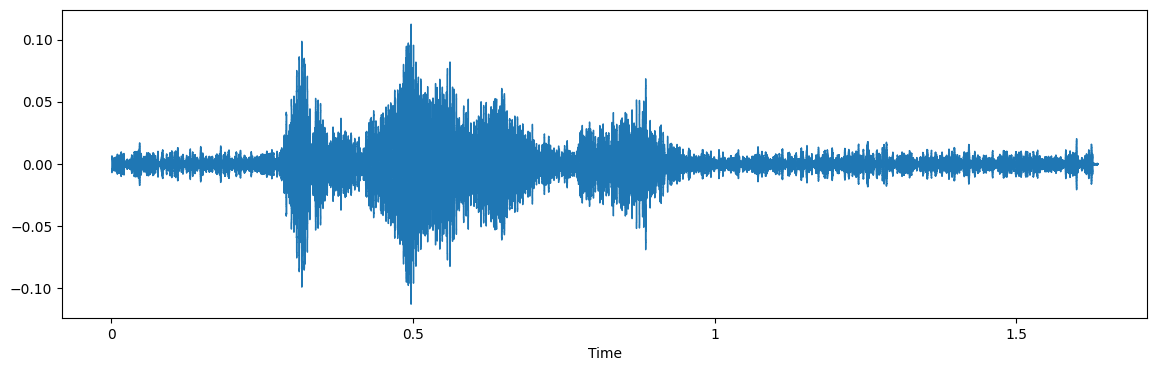

In [20]:
# Sample Audio
path = np.array(Crema_df.Path)[1]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

## Savee

In [21]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

In [22]:
# Joining them both
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
1     fear  /kaggle/input/surrey-audiovisual-expressed-emo...
2    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
3  disgust  /kaggle/input/surrey-audiovisual-expressed-emo...
4    angry  /kaggle/input/surrey-audiovisual-expressed-emo...

<Axes: xlabel='Emotions', ylabel='count'>

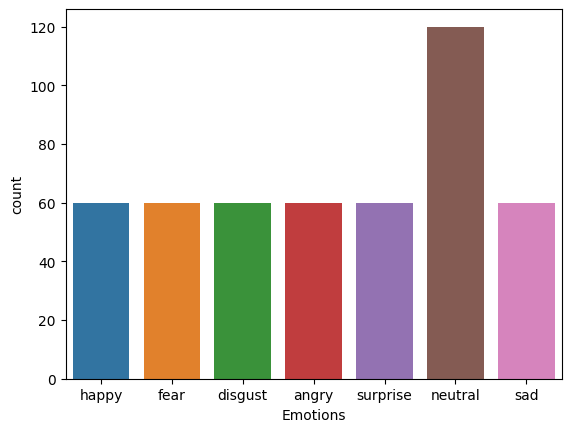

In [23]:
sns.countplot(data=Savee_df, x='Emotions')

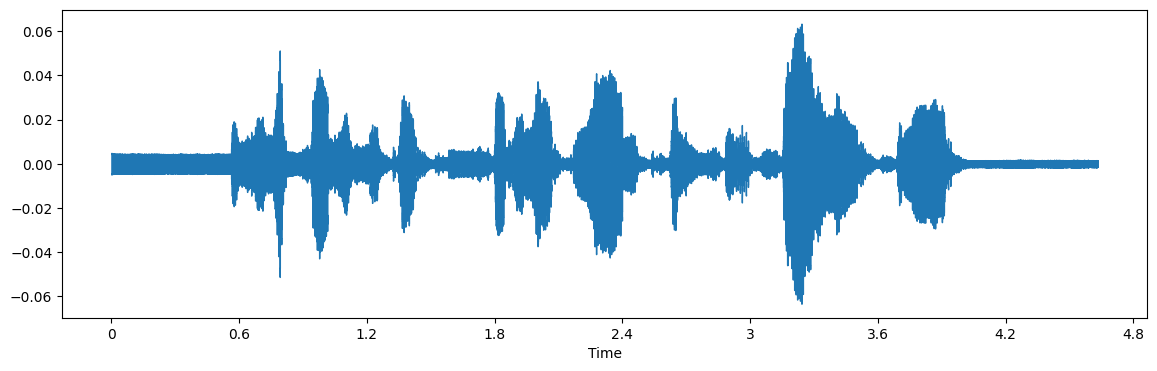

In [24]:
# Sample Audio
path = np.array(Savee_df.Path)[1]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

## Combining All

In [25]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.shape

(12162, 2)

In [26]:
data_path.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

<Axes: xlabel='Emotions', ylabel='count'>

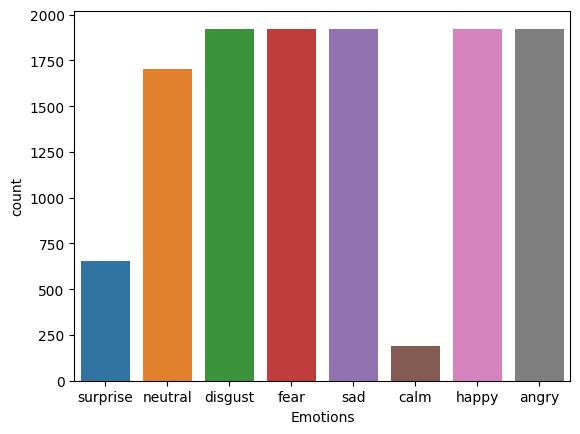

In [27]:
sns.countplot(data=data_path, x='Emotions')

In [28]:
data_path['Emotions'].value_counts()

Emotions
fear        1923
disgust     1923
happy       1923
sad         1923
angry       1923
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64

# Data Pre-Processing

## Exploring the Labels

In [29]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

### Fear

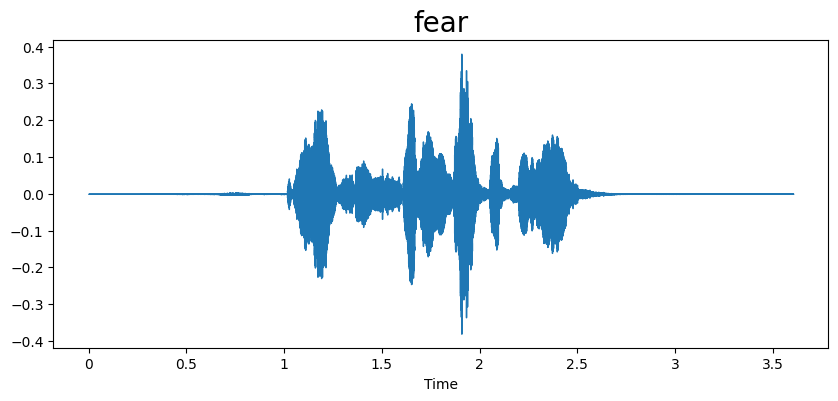

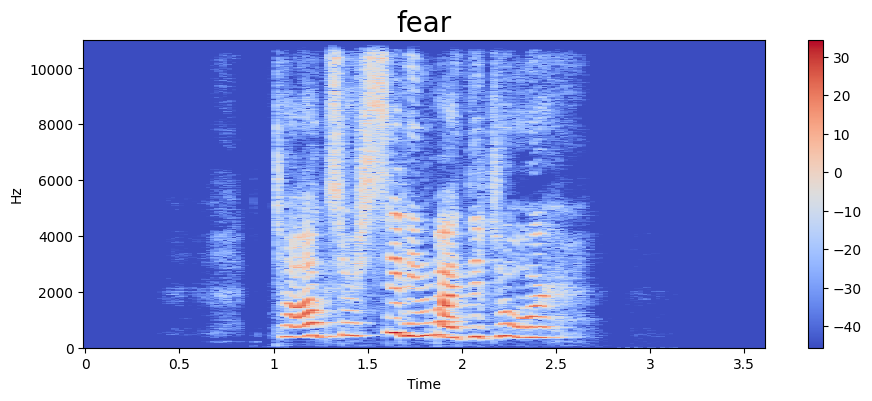

In [30]:
emotion = 'fear'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

### Anger

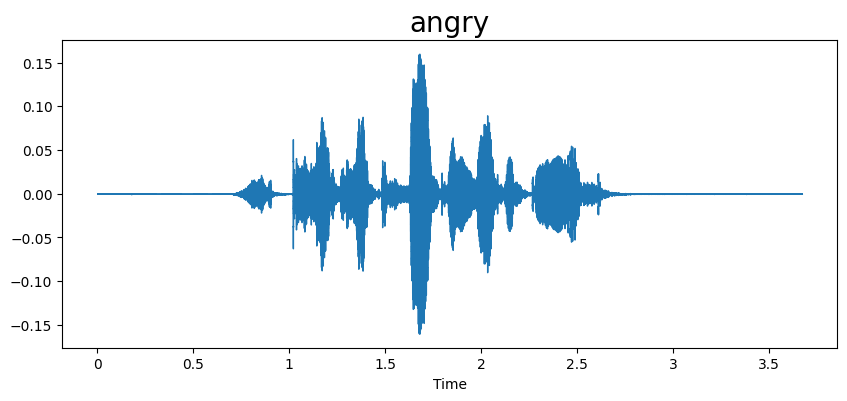

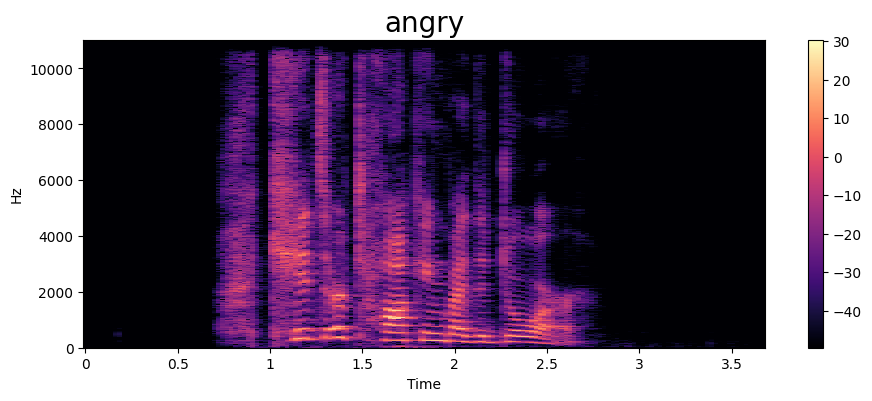

In [31]:
emotion = 'angry'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

### Disgust

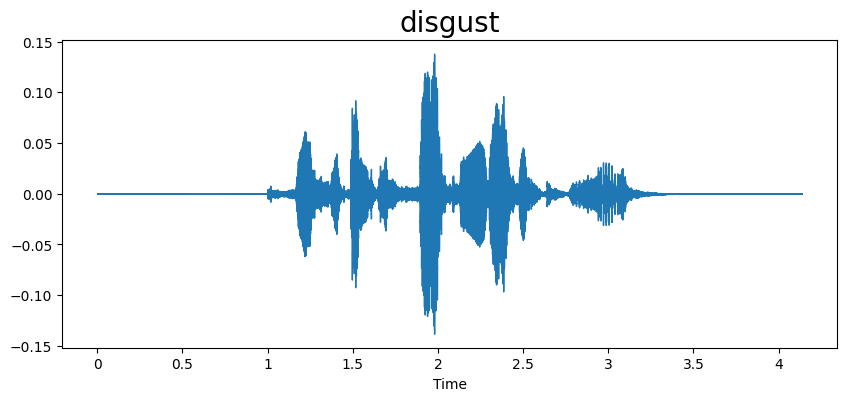

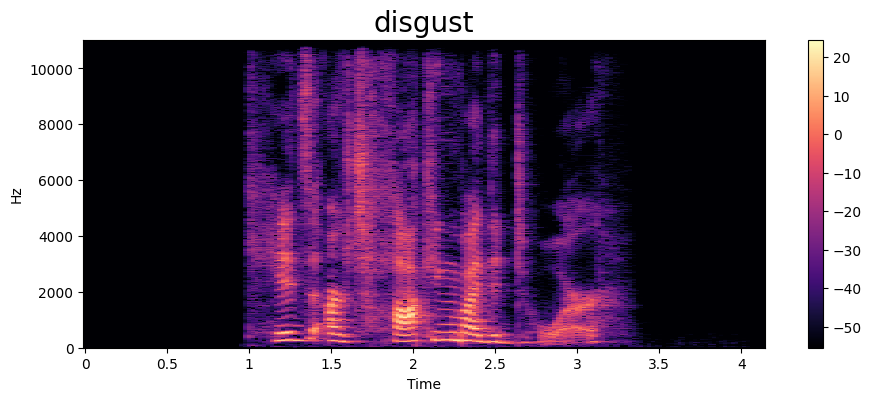

In [32]:
emotion = 'disgust'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

### Neutral

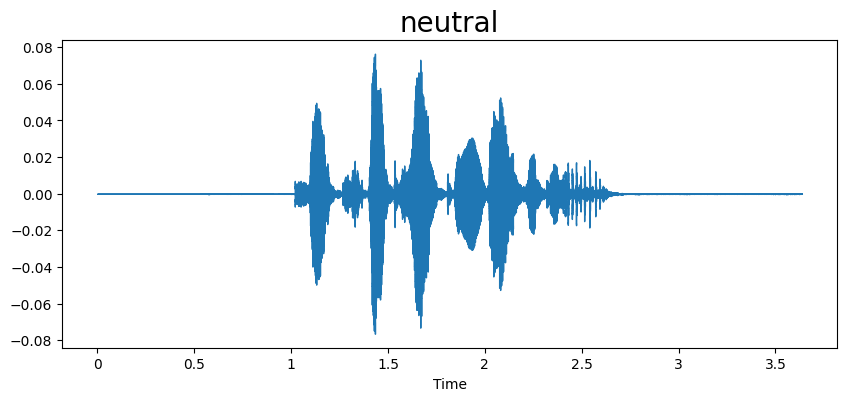

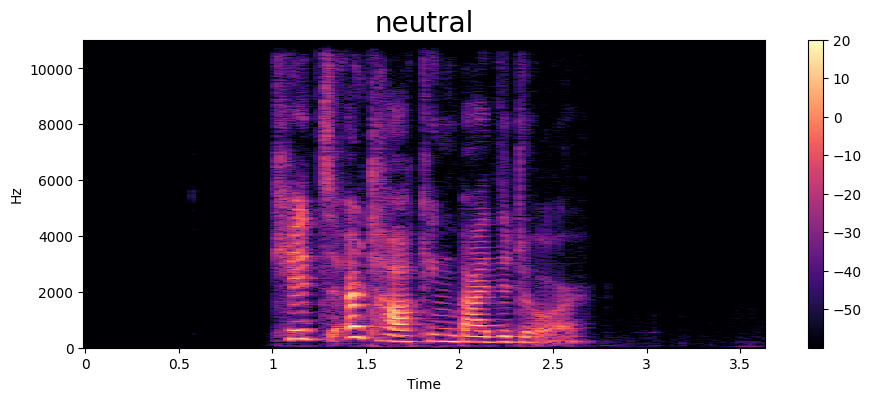

In [33]:
emotion = 'neutral'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

### Sad

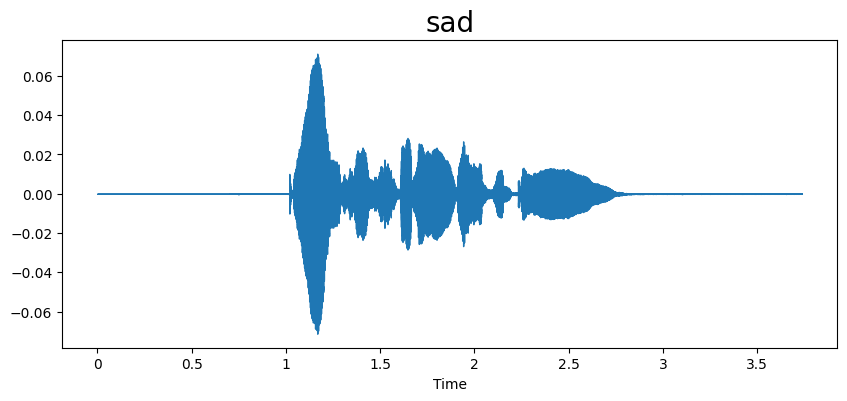

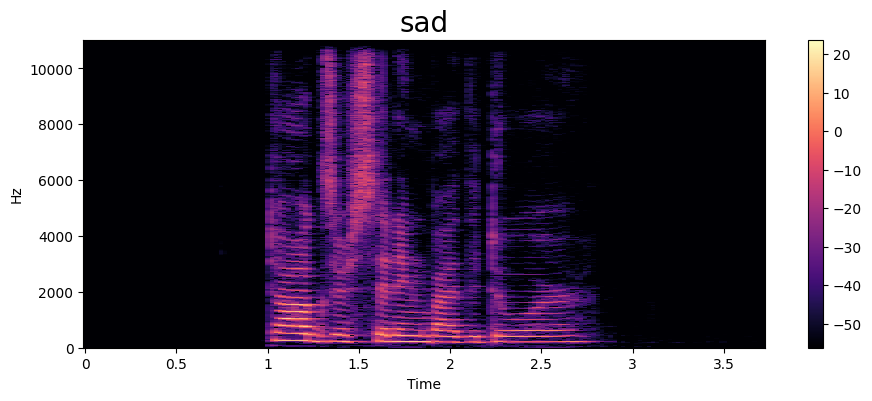

In [34]:
emotion = 'sad'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

### Happy

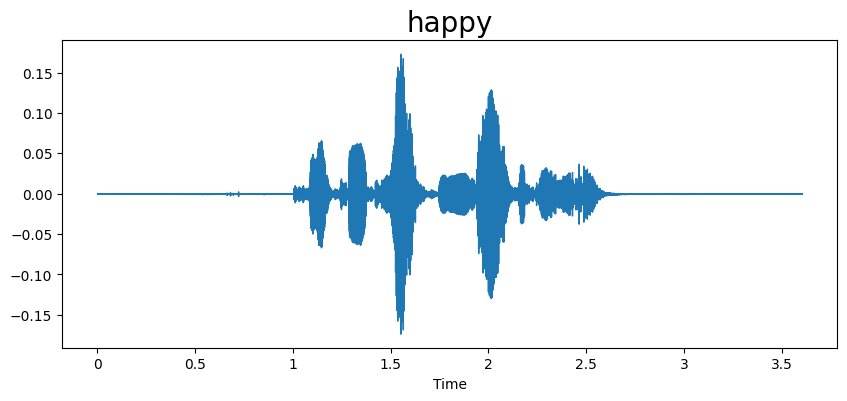

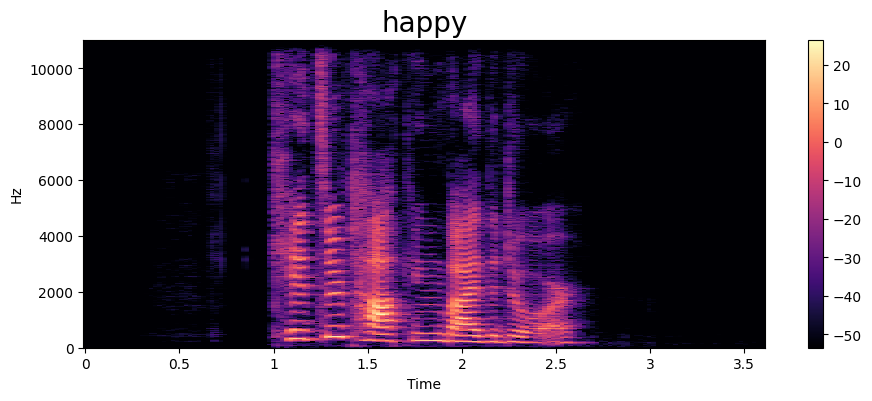

In [35]:
emotion = 'happy'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## Removing Error causing possibilities

In [36]:
data_path = data_path[data_path['Emotions'] != 'calm']
data_path

Emotions                                               Path
0    surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1     neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2     disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3     disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4     neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
..        ...                                                ...
475  surprise  /kaggle/input/surrey-audiovisual-expressed-emo...
476   neutral  /kaggle/input/surrey-audiovisual-expressed-emo...
477   neutral  /kaggle/input/surrey-audiovisual-expressed-emo...
478     angry  /kaggle/input/surrey-audiovisual-expressed-emo...
479     happy  /kaggle/input/surrey-audiovisual-expressed-emo...

[11970 rows x 2 columns]

<Axes: xlabel='Emotions', ylabel='count'>

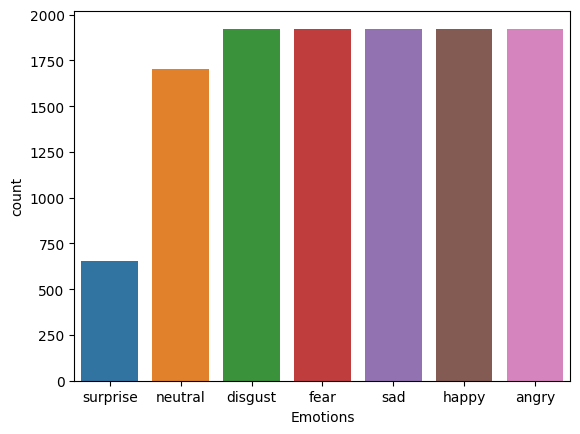

In [37]:
sns.countplot(data=data_path, x='Emotions')

## Shuffling

In [38]:
data_path = data_path.sample(frac=1)
data_path.head()

Emotions                                               Path
3181    angry  /kaggle/input/cremad/AudioWAV/1001_TIE_ANG_XX.wav
2170      sad  /kaggle/input/cremad/AudioWAV/1060_IWW_SAD_XX.wav
3416      sad  /kaggle/input/cremad/AudioWAV/1052_IWL_SAD_XX.wav
2146  disgust  /kaggle/input/cremad/AudioWAV/1061_TIE_DIS_XX.wav
1549    angry  /kaggle/input/cremad/AudioWAV/1062_IEO_ANG_HI.wav

In [39]:
data_path['Emotions'].value_counts()

Emotions
angry       1923
sad         1923
disgust     1923
fear        1923
happy       1923
neutral     1703
surprise     652
Name: count, dtype: int64

* Lets get even here... 
* We will use upsampling and downsampling both here
* We will keep 1800 of other emotions of the dataset and increase the number of neutral emotions.
* Let's remove the number of surprises we have for now...


## Deleting till 1800

In [40]:
# Emotions to reduce
emotions_to_reduce = ['fear', 'angry', 'happy', 'disgust', 'sad']

# Separate out the rows for emotions
reduced_data = (
    data_path[data_path['Emotions'].isin(emotions_to_reduce)]
    .groupby('Emotions')
    .head(1800)  # Keep only the first 1800 samples for these emotions
)

# Keep all samples for emotions not in emotions_to_reduce
other_data = data_path[~data_path['Emotions'].isin(emotions_to_reduce)]

# Combine the reduced emotions and the other emotions
data_path = pd.concat([reduced_data, other_data], ignore_index=True)


In [41]:
data_path['Emotions'].value_counts()

Emotions
angry       1800
sad         1800
disgust     1800
fear        1800
happy       1800
neutral     1703
surprise     652
Name: count, dtype: int64

In [42]:
data_path.Emotions.describe()

count     11355
unique        7
top       angry
freq       1800
Name: Emotions, dtype: object

## Removing the Surprises

<Axes: xlabel='Emotions', ylabel='count'>

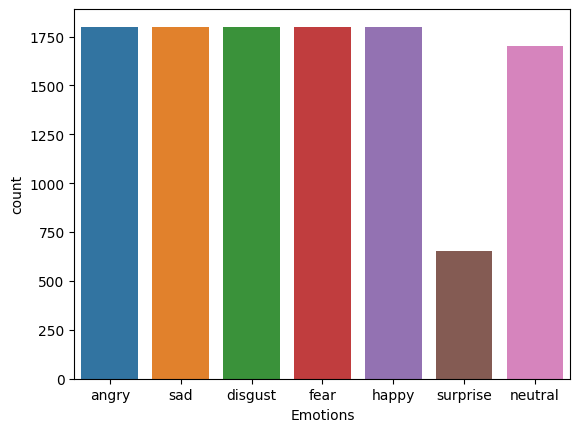

In [43]:
data_path = data_path[data_path['Emotions'] != 'surprises']
sns.countplot(data=data_path, x='Emotions')

## Duplicating Neutral Emotion Audio Samples
* We can duplicate a few random audio samples of Neutral Emotion till the count reaches that of the others

In [44]:
neutral_data = data_path[data_path['Emotions'] == 'neutral']
duplicates_needed = 1800 - len(neutral_data)
neutral_augmented = neutral_data.sample(duplicates_needed, replace=True, random_state=42)

# Combine the original and duplicated 'neutral' data
balanced_neutral_data = pd.concat([neutral_data, neutral_augmented])

# Combine all the balanced data
data_path = pd.concat([reduced_data, balanced_neutral_data])

## Verifying Count

In [45]:
print(data_path['Emotions'].value_counts())

Emotions
angry      1800
sad        1800
disgust    1800
fear       1800
happy      1800
neutral    1800
Name: count, dtype: int64


<Axes: xlabel='Emotions', ylabel='count'>

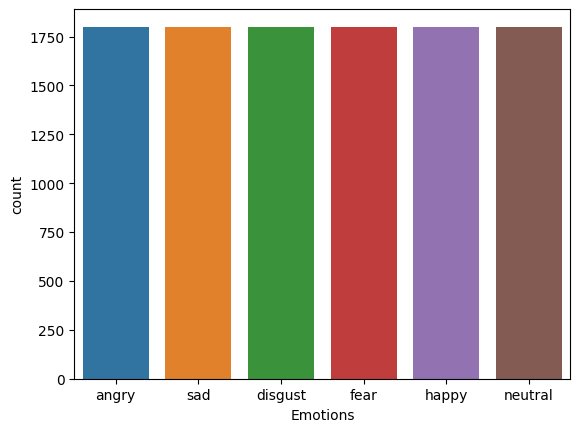

In [46]:
sns.countplot(data=data_path, x='Emotions')

## Data Augmentation

In [48]:
# Function for adding noise to audio
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Function for stretching the audio
def stretch(data, rate):
    return librosa.effects.time_stretch(data, rate=rate)

# Function for shifting the audio
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# Function for adding pitch to audio
def pitch(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor*12)

In [52]:
def noise(data, noise_factor=0.005):
    noise = torch.randn_like(data) * noise_factor
    return data + noise.to("cuda")

def stretch(data, rate):
    # Using torchaudio for time stretching
    return torchaudio.transforms.TimeStretch(rate)(data)

def shift(data, shift_max=1600):
    # Implement time shifting using torch.roll
    shift = torch.randint(-shift_max, shift_max, (1,))
    return torch.roll(data, int(shift), dims=0)

def pitch(data, sample_rate, pitch_factor=0):
    # Using torchaudio for pitch shifting
    return torchaudio.transforms.PitchShift(sample_rate, pitch_factor)(data)

In [47]:
# taking any example and checking for the techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)
# data and sample_rate = diff per path

### 1. Noise Injection

In [48]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

TypeError: randn_like(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

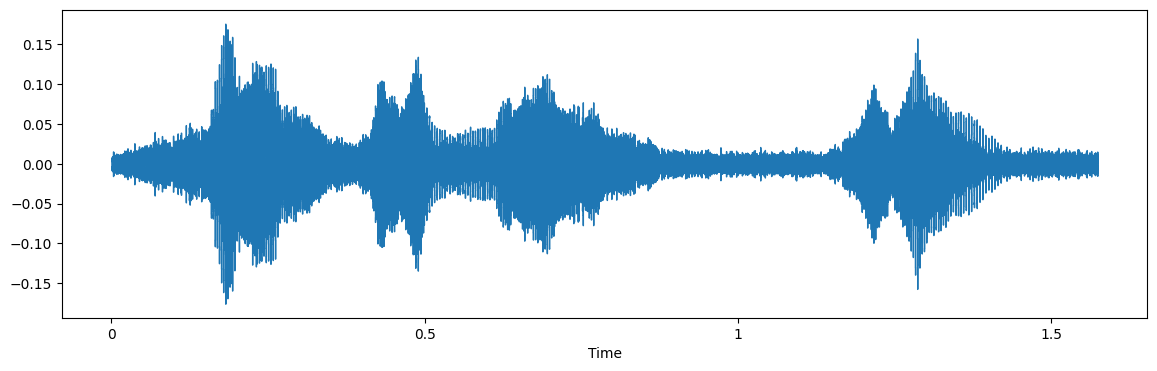

In [56]:
# Assuming data is a NumPy array
data_tensor = torch.from_numpy(data)

# If using GPU
data_tensor = data_tensor.to("cuda")

x = noise(data_tensor)

# Convert back to NumPy array for plotting
x_numpy = x.cpu().numpy()

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x_numpy, sr=sample_rate)
Audio(x_numpy, rate=sample_rate)

### 2. Stretching
* Changing speed

In [65]:
x = stretch(data, 0.7)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

NameError: name 'torchaudio' is not defined

In [66]:
data_tensor = torch.from_numpy(data).unsqueeze(0)

# If using GPU
data_tensor = data_tensor.to("cuda")

x = stretch(data_tensor)

x_numpy = x.cpu().numpy()

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x_numpy, sr=sample_rate)
Audio(x_numpy, rate=sample_rate)

NameError: name 'torchaudio' is not defined

### 3. Shifting

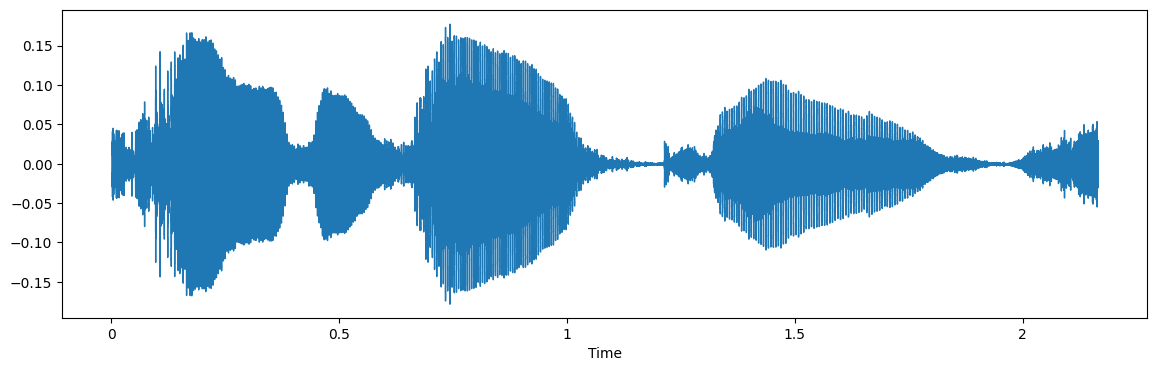

In [52]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### 4. Pitch

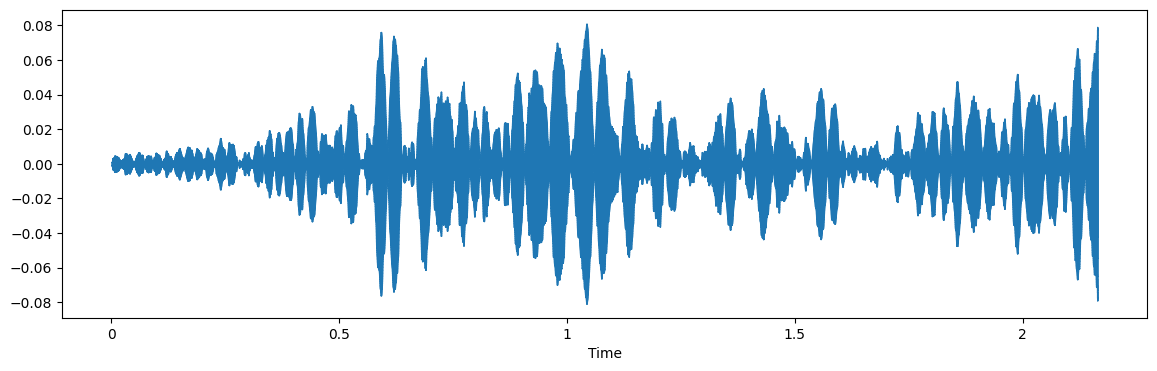

In [53]:
x = pitch(data, sample_rate, pitch_factor=np.random.uniform(-5, 5))
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Data Preprocessing

## Feature Extraction

In [164]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, 
#                                         n_mfcc=40
                                       ).T, axis=0)
    return mfcc

In [55]:
# import scipy.signal as sig
# pip install python_speech_features as psf

In [56]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    '''
    # LPC (Linear Predictive Coding)
    lpc_order = 16
#     lpc_coeff = sig.lpc(data, lpc_order)
    lpc_coeff = lpc(data, lpc_order)
    result = np.hstack((result, lpc_coeff))
    
    
    # LPCC (Linear Predictive Cepstral Coefficients)
#     lpcc = psf.lpc2lpcc(lpc_coeff, lpcc_order=lpc_order)
    lpcc = sig.lpc2cepstrum(lpc_coeff, lpc_order=lpc_order)
    result = np.hstack((result, lpcc))

    # PLPC (Perceptual Linear Predictive Coding)
#     plpc = psf.plp(data, sr=sample_rate, order=lpc_order)
    plpc = sig.lpc2cepstrum(lpc_coeff, lpc_order=lpc_order, mode='lpcc')
    result = np.hstack((result, plpc))
    '''
    return result

In [ ]:
def extract_features(data, sample_rate):
    result = torch.tensor([]).to('cuda')  # Start with an empty tensor on GPU
    
    # ZCR
    zcr = torch.tensor(librosa.feature.zero_crossing_rate(y=data).mean(axis=1)).to('cuda')
    result = torch.cat((result, zcr), dim=0)  # Concatenate on GPU

    # Chroma_stft
    stft = torch.tensor(np.abs(librosa.stft(data))).to('cuda')
    chroma_stft = torch.tensor(librosa.feature.chroma_stft(S=stft.cpu().numpy(), sr=sample_rate).mean(axis=1)).to('cuda')
    result = torch.cat((result, chroma_stft), dim=0)

    # MFCC
    mfcc = torch.tensor(librosa.feature.mfcc(y=data, sr=sample_rate).mean(axis=1)).to('cuda')
    result = torch.cat((result, mfcc), dim=0)

    # Root Mean Square Value
    rms = torch.tensor(librosa.feature.rms(y=data).mean(axis=1)).to('cuda')
    result = torch.cat((result, rms), dim=0)

    # MelSpectogram
    mel = torch.tensor(librosa.feature.melspectrogram(y=data, sr=sample_rate).mean(axis=1)).to('cuda')
    result = torch.cat((result, mel), dim=0)

    return result.cpu().numpy()  # Convert back to NumPy array if needed

In [57]:
def augment_and_extract_features(path, n_augment=100):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # Extract features from the original audio
    original_features = extract_features(data, sample_rate)

    # Randomly choose an augmentation technique
    augmentation_methods = [noise, stretch, shift, pitch]
    method = random.choice(augmentation_methods)

    # Apply the chosen augmentation
    if method == pitch:
        augmented_data = method(data, sample_rate, pitch_factor=np.random.uniform(-5, 5))
    elif method == stretch:
        augmented_data = method(data, rate=np.random.uniform(0.5, 1.5))
    else:
        augmented_data = method(data)

    # Extract features from the augmented audio
    augmented_features = extract_features(augmented_data, sample_rate)

    # Stack original and augmented features vertically
    combined_features = np.vstack((original_features, augmented_features))

    return combined_features

In [ ]:
# Augmentation and feature extraction
def augment_and_extract_features(path, n_augment=100):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # Extract features from the original audio
    original_features = extract_features(data, sample_rate)

    # Randomly choose an augmentation technique
    augmentation_methods = [noise, stretch, shift, pitch]
    method = random.choice(augmentation_methods)

    # Apply the chosen augmentation
    if method == pitch:
        augmented_data = method(data, sample_rate, pitch_factor=np.random.uniform(-5, 5))
    elif method == stretch:
        augmented_data = method(data, rate=np.random.uniform(0.5, 1.5))
    else:
        augmented_data = method(data)

    # Extract features from the augmented audio
    augmented_features = extract_features(augmented_data, sample_rate)

    # Stack original and augmented features vertically
    combined_features = np.vstack((original_features, augmented_features))

    return combined_features

In [58]:
with tf.device('/device:GPU:0'):
    # Your model and data operations here
    # Lists to hold the features and corresponding labels
    X, Y = [], []

    # Loop through the dataset
    for path, emotion in zip(data_path.Path, data_path.Emotions):
        # Get features for the original and augmented audio
        features = augment_and_extract_features(path)

        # Append each set of features to X, and the corresponding emotion to Y
        for feature in features:
            X.append(feature)
            Y.append(emotion)

    # Convert to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

# Shuffle the dataset
X, Y = shuffle(X, Y, random_state=42)

In [ ]:
# Dataset processing
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    features = augment_and_extract_features(path)
    for feature in features:
        X.append(feature)
        Y.append(emotion)

    X = np.array(X)
    Y = np.array(Y)

# Shuffle the dataset
X, Y = shuffle(X, Y, random_state=42)

In [59]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.139096  0.333292  0.320891  0.564762  0.890306  0.508387  0.310562   
1  0.090827  0.530408  0.525987  0.522411  0.566150  0.582753  0.681158   
2  0.054914  0.456776  0.455182  0.487617  0.619038  0.561608  0.521591   
3  0.065943  0.522813  0.541843  0.464701  0.440539  0.470312  0.469733   
4  0.064688  0.495959  0.512215  0.516911  0.663971  0.585424  0.480354   

          7         8         9  ...           153           154  \
0  0.288128  0.280131  0.243364  ...  4.253329e-04  4.860525e-04   
1  0.665738  0.587151  0.555802  ...  3.562932e-04  3.568417e-04   
2  0.634610  0.637008  0.674119  ...  1.026796e-07  9.475864e-08   
3  0.563256  0.594305  0.677423  ...  7.552022e-09  6.954471e-09   
4  0.547559  0.616829  0.699051  ...  4.830709e-07  4.475020e-07   

            155           156           157           158           159  \
0  6.255026e-04  3.185781e-04  4.805420e-04  2.619972e-04  1.995260e-04   
1  3.714003e-04  3.789360e-04  3.893182e-04  4.097406e-04  3.666406e-04   
2  8.917083e-08  8.502693e-08  8.194533e-08  7.972814e-08  7.811668e-08   
3  6.722962e-09  6.371565e-09  6.733975e-09  6.491431e-09  5.948110e-09   
4  4.222648e-07  4.034748e-07  3.894839e-07  3.794291e-07  3.721277e-07   

            160           161  labels  
0  1.102476e-04  9.075972e-06    fear  
1  3.774749e-04  3.778509e-04   angry  
2  7.707226e-08  7.642520e-08   happy  
3  6.103524e-09  5.954924e-09   angry  
4  3.673998e-07  3.644760e-07   happy  

[5 rows x 163 columns]

In [60]:
print(data_path.shape)
data_path.head()

(10800, 2)


Emotions                                               Path
6034    angry  /kaggle/input/cremad/AudioWAV/1041_IWW_ANG_XX.wav
2480      sad  /kaggle/input/toronto-emotional-speech-set-tes...
2027  disgust  /kaggle/input/cremad/AudioWAV/1028_IEO_DIS_LO.wav
1317      sad  /kaggle/input/toronto-emotional-speech-set-tes...
6292     fear  /kaggle/input/cremad/AudioWAV/1054_ITH_FEA_XX.wav

In [144]:
len(X), len(Y)

(21600, 21600)

In [150]:
data_path.shape

(10800, 2)

We have applied data augmentation and extracted the features for each audio files and saved them.

As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [62]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [65]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

splitting it in the ratio 3:1

In [68]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16200, 162), (16200, 6), (5400, 162), (5400, 6))

In [74]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16200, 162), (16200, 6), (5400, 162), (5400, 6))

In [80]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16200, 162, 1), (16200, 6), (5400, 162, 1), (5400, 6))

In [165]:
# extract_mfcc(df['speech'][0])
extract_mfcc(data_path['Path'][44])

TypeError: Invalid file: 44    /kaggle/input/toronto-emotional-speech-set-tes...
44    /kaggle/input/cremad/AudioWAV/1028_MTI_HAP_XX.wav
44    /kaggle/input/surrey-audiovisual-expressed-emo...
Name: Path, dtype: object

In [ ]:
# X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))
X_mfcc = data_path['Path'].apply(lambda x: extract_mfcc(x))
X_mfcc

In [ ]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

In [93]:
## input split
X = np.expand_dims(X, -1)
X.shape

(21600, 162, 1)

In [ ]:
enc = OneHotEncoder()
# y = enc.fit_transform(data_path[['label']])
y = enc.fit_transform(data_path[['Emotion']])

In [ ]:
y = y.toarray()
y.shape

# LSTM Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
# Train the model
history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)

## Plot the results

In [ ]:
epochs = list(range(50))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Predict

In [ ]:
y_train = model.predict(x_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

## Accuracy

In [ ]:
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.2f}")

## Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

## ROC-AUC Curve

In [ ]:
y_test_bin = label_binarize(y_true_classes, classes=range(6))  # Replace 7 with the number of classes
n_classes = y_test_bin.shape[1]

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Each Class")
plt.legend(loc="lower right")
plt.show()

# CNN Model

In [178]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)              │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,222 (2.13 MB)

 Trainable params: 557,222 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [198]:
y_train.shape

(16200, 6)

In [206]:
x_test.shape

(5400, 162, 1)

In [201]:
if tf.device('/device:GPU:0'):
    print(tf.device)
else:
    print("False")

<function device_v2 at 0x7e2702b424d0>


In [200]:
with tf.device('/device:GPU:0'):
    rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, 
                             patience=2, min_lr=0.0000001)
    history=model.fit(x_train, y_train, batch_size=128, epochs=70, 
                      validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/70
125/127 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6100 - loss: 0.9823

ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 6)

## Accuracy of Model

In [195]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 6)

## Prediction

In [191]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [192]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0              sad          fear
1              sad           sad
2          neutral       neutral
3          neutral       disgust
4             fear          fear
5            happy         happy
6            happy         happy
7            angry         angry
8            happy       disgust
9          neutral       neutral

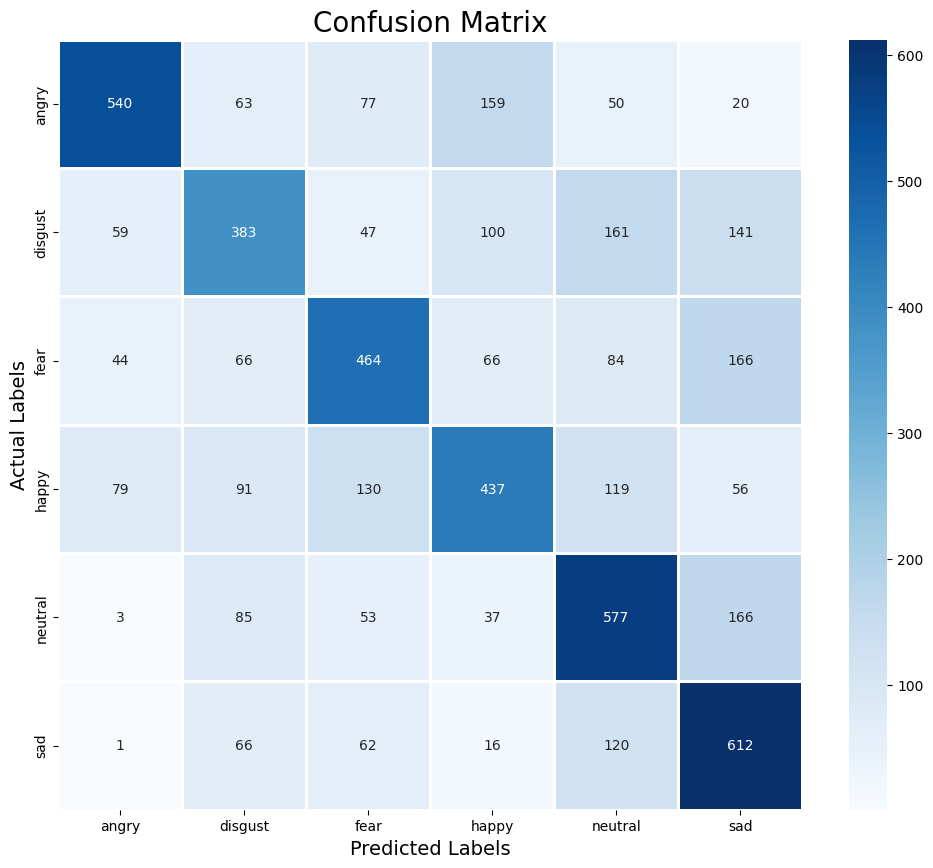

In [193]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [194]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.74      0.59      0.66       909
     disgust       0.51      0.43      0.47       891
        fear       0.56      0.52      0.54       890
       happy       0.54      0.48      0.51       912
     neutral       0.52      0.63      0.57       921
         sad       0.53      0.70      0.60       877

    accuracy                           0.56      5400
   macro avg       0.57      0.56      0.56      5400
weighted avg       0.57      0.56      0.56      5400



* Our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
* We overall achieved 61% accuracy on our test data and its decent.
